In [130]:
# import the modules we need. 

import ase
from pymatgen import Structure
from ase.io import read, write
from ase import Atoms
from icet import (ClusterSpace, StructureContainer,
                  CrossValidationEstimator, ClusterExpansion)
from pymatgen.io.ase import AseAtomsAdaptor
from tqdm import tqdm
from icet.tools.structure_generation import occupy_structure_randomly

from ase import Atom
from ase.build import bulk
from icet import ClusterSpace
from icet.tools.structure_generation import *

import json


from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.octahedral_analysis import *
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe


import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["mathtext.fontset"] ='custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica'
plt.rcParams["font.size"] = "8"
plt.rcParams['axes.linewidth'] = 0.75
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4

! ls

FIG_4_O_environments_O_vacancy_formation_energies.ipynb
Figure_4-oxygen_environments__oxygen_vacancy_formation_energies.png
relaxed_sqs.cif
test.png
wrong_pos_FIG_4_O_environments_O_vacancy_formation_energies.ipynb


In [131]:
! ls ../../../Data/

Jsons           datasets        structure_files


In [132]:
path = '../../../Data/'

sqs = read(mv /structure_files/LNMO_SQS.cif')
sqs = AseAtomsAdaptor.get_structure(sqs)

# Note that the 'pristine model' contains Na in the Li layer
pristine = read(f'{path}/structure_files/LNMO_pristine_from_CE_MC.cif')
pristine = AseAtomsAdaptor.get_structure(pristine)

# Note that to obtain the pristine model, the cluster expansion uses Na as a dummy atom 
# in the Li layer (to prevent mixing between Li in the TM layer and Li in the Li layer)
# so to get the correct environments in this 
pristine['Na'] = 'Li'
#print(pristine)

SyntaxError: EOL while scanning string literal (<ipython-input-132-e3772181769a>, line 3)

In [ ]:
recipe_O = PolyhedraRecipe( method='distance cutoff', 
                          coordination_cutoff=2.5, 
                          central_atoms='O',
                          vertex_atoms=['Li','Mn','Ni'])

In [ ]:
def get_envs(structure):
    #structure = AseAtomsAdaptor.get_structure(structure)
    config_O = Configuration( structure=structure, recipes=[recipe_O] )

    O_Li6 = []
    O_Li5 = []
    O_Li4 = []
    O_Li3 = []
    O_Li2 = []
    O_Li1 = []
    O_Li0 = []

    for p in config_O.polyhedra:
        if   p.vertex_labels.count('Li') == 6:
            O_Li6.append(p)
        elif p.vertex_labels.count('Li') == 5:
            O_Li5.append(p)
        elif p.vertex_labels.count('Li') == 4:
            O_Li4.append(p)
        elif p.vertex_labels.count('Li') == 3:
            O_Li3.append(p)
        elif p.vertex_labels.count('Li') == 2:
            O_Li2.append(p)
        elif p.vertex_labels.count('Li') == 1:
            O_Li1.append(p)
        elif p.vertex_labels.count('Li') == 0:
            O_Li0.append(p)

            
    total = len(config_O.polyhedra)
    print(total)

    frac_O_Li6 = len(O_Li6) / total * 100
    frac_O_Li5 = len(O_Li5) / total * 100
    frac_O_Li4 = len(O_Li4) / total * 100
    frac_O_Li3 = len(O_Li3) / total * 100
    frac_O_Li2 = len(O_Li2) / total * 100
    frac_O_Li1 = len(O_Li1) / total * 100
    frac_O_Li0 = len(O_Li0) / total * 100
    
    sites_list = [frac_O_Li6, frac_O_Li5, frac_O_Li4, frac_O_Li3, 
              frac_O_Li2, frac_O_Li1, frac_O_Li0 ]
    
    return sites_list

sites_list  = get_envs(sqs)
p_sites_list  = get_envs(pristine)

In [ ]:
# Reminder - need to label the origin of 'data disordered' and 'data'

import numpy as np
from numpy import genfromtxt
LNMO_pristine_O_vac_data = (genfromtxt(f'{path}/datasets/LNMO_pristine_O_vac_data.dat'))
print(LNMO_pristine_O_vac_data)
LNMO_disordered_O_vac_data = (genfromtxt(f'{path}/datasets/LNMO_disordered_O_vac_data.dat'))
print(LNMO_disordered_O_vac_data)


In [ ]:
SQS_fully_lithiated = {'struc':[], 'E': [], 'comp':[], 'vol':[]}
O2 = {'struc':[], 'E': [], 'comp':[]}
SQS_1_O_vac = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}
SQS_2_O_vac = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}
SQS_3_O_vac = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}

def get_json(filename, results):

    with open(f'{path}/Jsons/{filename}.json') as data:
            cluster_data = json.load(data)
    for n, calculation in enumerate(cluster_data['calculation_results']):
        atoms = ase.Atoms(numbers=calculation['structure']['numbers'],
                          positions=calculation['structure']['positions'],
                          pbc=calculation['structure']['pbc'],
                          cell=calculation['structure']['cell'])
        numbers = atoms.numbers
        epfu = float(calculation['energy']) *27.2114
        x_O = ( np.count_nonzero(numbers == 8) / 48 ) 
        results['E'].append(epfu)
        results['comp'].append(x_O)
        results['struc'].append(atoms)

get_json('LNMO_SQS_fully_lithiated',SQS_fully_lithiated)
get_json('LNMO_SQS_1_O_vac',SQS_1_O_vac)
get_json('LNMO_SQS_2_O_vac',SQS_2_O_vac)
get_json('LNMO_SQS_3_O_vac',SQS_3_O_vac)
get_json('O2',O2)



In [ ]:
for e in SQS_1_O_vac['E']:
    O_vac_form_E = e - SQS_fully_lithiated['E'][0] + (0.5*O2['E'][0])
    print(O_vac_form_E)
    SQS_1_O_vac['O_vac_form_E'].append(O_vac_form_E)

    

In [133]:
struc = AseAtomsAdaptor.get_structure(SQS_fully_lithiated['struc'][0])
config_O = Configuration( structure=struc, recipes=[recipe_O] )
O_coord = [ 6- p.vertex_labels.count('Li') for p in config_O.polyhedra ]

In [134]:
OTM0 = []
OTM1 = []
OTM2 = []
OTM3 = []
OTM4 = []
OTM5 = []
for c, e in zip(O_coord, SQS_1_O_vac['O_vac_form_E']):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
for c, e in zip(LNMO_disordered_O_vac_data[:,0], LNMO_disordered_O_vac_data[:,1]):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
print(OTM0)    

[0.09383021207577258, -0.352668589041059, -0.4058927269088599, -4.222]


In [135]:
LNMO_disordered_O_vac_data = [OTM0, OTM1, OTM2, OTM3, OTM4, OTM5]
print(LNMO_disordered_O_vac_data)

[[0.09383021207577258, -0.352668589041059, -0.4058927269088599, -4.222], [1.9886380908410501, 3.122481345488268, 1.3470319189927977, 2.1343012592387822, 2.0658926159940165, 0.4396343159587559, 0.225, 0.195], [3.531208274243909, 2.1516926091262576, 3.142305666637185, 2.6369320083740604, 2.9009136093645793, 2.2812376490892348, 2.2419261558079597, 2.541302713272671, 2.8921074560475972, 3.252317547272469, 1.9366414591768262, 3.821178939249876, 3.3938742433074367, 2.745058955215427, 1.9551928311684605], [3.614607405672359, 5.305047602216291, 4.176477644765328, 2.094925547075036, 3.8761818863549706, 3.817850712859581, 2.594931756668302, 4.030040584095332, 3.937895980952817, 3.6052404255005968, 3.051697963323022, 2.2279408567683276, 3.3523550892114145], [3.656772558517332, 3.045198248290035, 4.9642016875423, 3.6015078378241014, 4.030856654104355, 4.001781817465599, 3.905603396180595, 5.318648676327939, 3.9212455973593023, 4.7, 4.2, 3.8, 4.35], [4.894558463069188, 3.9549964410816756]]


In [136]:
OTM0 = []
OTM1 = []
OTM2 = []
OTM3 = []
OTM4 = []
OTM5 = []
for c, e in zip(LNMO_pristine_O_vac_data[:,0], LNMO_pristine_O_vac_data[:,1]):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
print(OTM0)    
LNMO_pristine_O_vac_data = [OTM0, OTM1, OTM2, OTM3, OTM4, OTM5]
print(LNMO_pristine_O_vac_data)

[99999.0]
[[99999.0], [99999.0], [3.388, 2.564, 3.598], [4.512, 3.847, 4.571, 4.075], [99999.0], []]


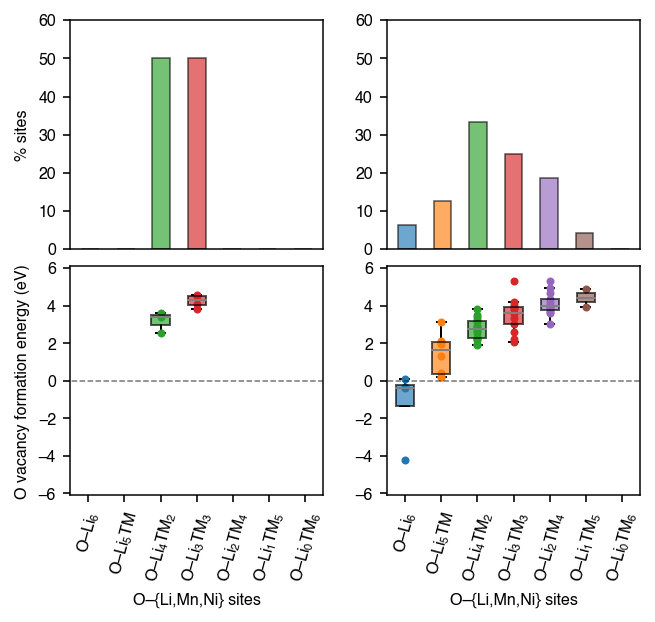

In [137]:


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(4.4, 3.3))

a = axes[0,0]
b = axes[0,1]
c = axes[1,0]
d = axes[1,1]

O_bar_colors = ['tab:blue',
              'tab:orange',
              'tab:green',
              'tab:red', 
              'tab:purple',
              'tab:brown',
              'tab:pink']

x = ['O–Li$_6$','O–Li$_5$TM',
     'O–Li$_4$TM$_2$','O–Li$_3$TM$_3$',
     'O–Li$_2$TM$_4$','O–Li$_1$TM$_5$','O–Li$_0$TM$_6$']

N= len(x)
ind = np.arange(N) 
width = 0.5
linewidth = 0.75

a.bar(ind , p_sites_list , width, color=O_bar_colors, 
      alpha=0.65, edgecolor='k', linewidth = linewidth)

b.bar(ind , sites_list , width, color=O_bar_colors, 
      alpha=0.65, edgecolor='k', linewidth = linewidth)

x1 = [-1,10]
y1 = [0,0]

colors = ['tab:blue',
              'tab:orange',
              'tab:green',
              'tab:red', 
              'tab:purple',
              'tab:brown',
              'tab:pink']
props = dict(color='black')

flierprops = dict(marker='o', markerfacecolor='grey', markersize=1,
                  linestyle='none')
medianprops = dict(linestyle='-', linewidth=1.0, color='grey')

box_1 = c.boxplot(LNMO_pristine_O_vac_data, flierprops=flierprops, 
                  medianprops=medianprops, patch_artist=True)
box_2 = d.boxplot(LNMO_disordered_O_vac_data, flierprops=flierprops, 
                  medianprops=medianprops, patch_artist=True)

marker_size = 3
c.plot([3]*len(LNMO_pristine_O_vac_data[2]),LNMO_pristine_O_vac_data[2],'o', 
       color='tab:green', markersize = marker_size)
c.plot([4]*len(LNMO_pristine_O_vac_data[3]),LNMO_pristine_O_vac_data[3],'o',  
       color='tab:red', markersize = marker_size)

for patch, color in zip(box_1['boxes'], colors):
    patch.set_edgecolor('k')
    patch.set_facecolor(color)
    patch.set_alpha(0.65)
    
d.plot([1]*len(LNMO_disordered_O_vac_data[0]),LNMO_disordered_O_vac_data[0],'o', 
       color='tab:blue', markersize = marker_size)
d.plot([2]*len(LNMO_disordered_O_vac_data[1]),LNMO_disordered_O_vac_data[1],'o', 
       color='tab:orange', markersize = marker_size)
d.plot([3]*len(LNMO_disordered_O_vac_data[2]),LNMO_disordered_O_vac_data[2],'o', 
       color='tab:green', markersize = marker_size)
d.plot([4]*len(LNMO_disordered_O_vac_data[3]),LNMO_disordered_O_vac_data[3],'o', 
       color='tab:red', markersize = marker_size)
d.plot([5]*len(LNMO_disordered_O_vac_data[4]),LNMO_disordered_O_vac_data[4],'o', 
       color='tab:purple', markersize = marker_size)
d.plot([6]*len(LNMO_disordered_O_vac_data[5]),LNMO_disordered_O_vac_data[5],'o', 
       color='tab:brown', markersize = marker_size)

for patch, color in zip(box_2['boxes'], colors):
    patch.set_edgecolor('k')
    patch.set_facecolor(color)
    patch.set_alpha(0.65)

a.set_xticklabels([])
a.set_xticks([])

a.set_ylabel('% sites')

left_axes = [a,b]
for axis in left_axes:
    axis.set_yticks([])
    axis.set_xticklabels([])    
    axis.set_xticks([])    
    axis.set_yticks([0,10,20,30,40,50, 60])

c.set_ylabel('O vacancy formation energy (eV)')

bottom_axes = [c, d]
for axis in bottom_axes:
    axis.set_xlabel('O–{Li,Mn,Ni} sites')
    axis.set_xticks([1,2,3,4,5,6,7])
    axis.set_xlim([0.5, 7.5])
    axis.set_ylim([-6.1, 6.1])
    axis.plot(x1 , y1 , '--', color='black', 
      alpha=0.55)
    axis.set_xticks(ind+1)
    axis.set_xticklabels(x, rotation = 75)

text_y_position = 53
text_y_position_2 = 55

fig.subplots_adjust(bottom=0.0, top=1.0, left=0.0, right=0.9,
                    wspace=0.25, hspace=0.075)

plt.savefig('Figure_4-oxygen_environments__oxygen_vacancy_formation_energies.png', 
            dpi=300, bbox_inches='tight')
